<br><br><br>

### **ensemble (soft voting)**

In [17]:
import pandas as pd
import numpy as np

In [18]:
import pickle as pkl

def num_to_label(label):
    origin_label = []
    with open('dict_num_to_label.pkl', 'rb') as f:
        dict_num_to_label = pkl.load(f)
    for v in label:
        origin_label.append(dict_num_to_label[v])
    return origin_label

In [19]:
import os

use_files = []
PATH = '../Downloads/'  # root PATH
for idx, file_nm in enumerate(os.listdir(PATH)):
    if 'output_' in file_nm:
        use_files.append(PATH + file_nm)
use_files

['../Downloads/output_백인진.csv',
 '../Downloads/output_이준원.csv',
 '../Downloads/output_권현정.csv',
 '../Downloads/output_강혜빈.csv',
 '../Downloads/output_이용우.csv']

In [20]:
from typing import *

def ensemble(files: List):
    ensemble_df = pd.DataFrame({
        'id': [i for i in range(7765)],
        'pred_label': ["" for _ in range(7765)],
        'probs': [np.zeros(30,) for _ in range(7765)]
    })

    to_array = lambda s: np.asarray(list(map(float, s[1:-1].replace(' ', '').split(','))))
    for file in files:
        df = pd.read_csv(file)
        ensemble_df['probs'] += df['probs'].map(to_array)    
    
    
    ensemble_df['probs'] = ensemble_df['probs'].map(lambda arr: arr / len(use_files))
    ensemble_df['pred_label'] = num_to_label(ensemble_df['probs'].map(lambda arr: arr.argmax(-1)))
    
    ensemble_df['probs'] = ensemble_df['probs'].map(lambda arr: str(list(arr)))
    return ensemble_df

In [21]:
result = ensemble(use_files)
len(result)

7765

In [22]:
result

,id,pred_label,probs
0,0,org:product,"[0.09954920743714285, 0.005771583637142857, 0...."
1,1,per:alternate_names,"[0.02546120591142857, 0.002186203718, 0.002460..."
2,2,no_relation,"[0.9527212551428571, 0.0015023808562857142, 0...."
3,3,no_relation,"[0.8787222348571427, 0.0019978318851428573, 0...."
4,4,no_relation,"[0.6129719471999999, 0.3290711548, 0.001761246..."
...,...,...,...
7760,7760,org:place_of_headquarters,"[0.2521667873142857, 0.005531984534285714, 0.0..."
7761,7761,no_relation,"[0.945188065142857, 0.0034396113937142855, 0.0..."
7762,7762,org:top_members/employees,"[0.0013546687157142859, 0.9563543922857143, 0...."
7763,7763,no_relation,"[0.8169272654285713, 0.0017696397099999997, 0...."


In [25]:
result.to_csv('./soft_ensemble.csv', index=False)

<br><br><br>

### **viz**

In [23]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [24]:
value_counts_1 = result['pred_label'].value_counts().sort_values(ascending=True)
pd.DataFrame(value_counts_1)

,pred_label
per:religion,8
org:dissolved,8
org:founded_by,9
per:schools_attended,10
org:political/religious_affiliation,11
per:place_of_death,12
per:date_of_birth,13
per:place_of_birth,14
per:other_family,19
org:number_of_employees/members,20


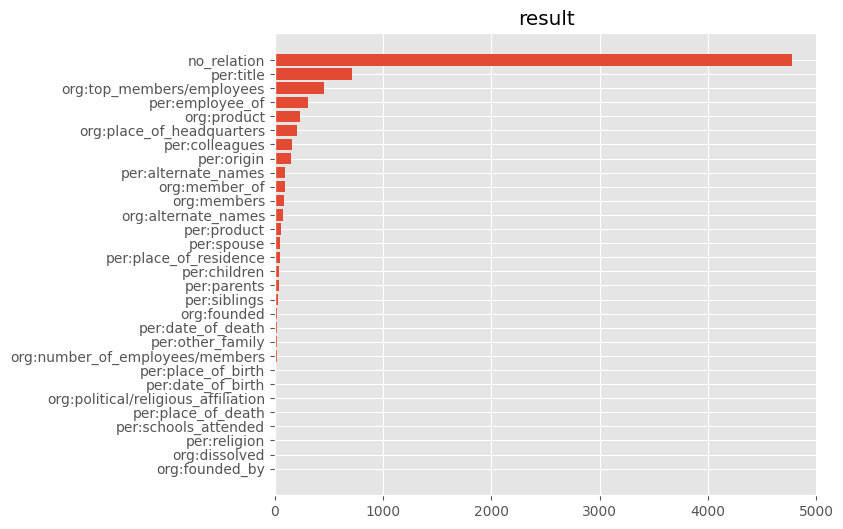

In [9]:

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.set_title('result')
ax.barh(value_counts_1.index, value_counts_1)
plt.show()

<br><br><br>

### **ensemble (Hard voting)**

In [21]:
def ensemble(files: List):
    ensemble_df = pd.DataFrame({
        'id': [i for i in range(7765)],
        'pred_label': ["" for _ in range(7765)],
        'probs': [np.zeros((30,)) for _ in range(7765)]
    })

    to_array = lambda s: np.array(list(map(float, s[1:-1].replace(' ', '').split(','))))
    for idx, file in enumerate(files):
        df = pd.read_csv(file)
        ensemble_df[f'pred_label_{idx}'] = df['pred_label']
        ensemble_df[f'probs_{idx}'] = df['probs'].map(to_array)


    comp_columns = [column for column in ensemble_df.columns if 'pred_label_' in column]
    for i, item in ensemble_df.iterrows():
        hard_vote =  pd.Series(item[comp_columns]).value_counts().sort_values(ascending=False).index[0]
        hard_vote_idx = [int(k[-1]) for k in item[item.astype(str)==hard_vote].index]
        
        for idx in hard_vote_idx:
            ensemble_df.at[i, 'probs'] = ensemble_df.loc[i, 'probs'] + ensemble_df.loc[i, f'probs_{idx}']
        ensemble_df.at[i, 'probs'] = ensemble_df.loc[i, 'probs'] / len(hard_vote_idx)
        
        ensemble_df.loc[i, 'pred_label'] = ensemble_df.loc[i, 'probs'].argmax(-1)    
    
    ensemble_df['pred_label'] = num_to_label(ensemble_df['pred_label'])
    ensemble_df['probs'] = ensemble_df['probs'].map(lambda arr: str(list(arr)))

    use_columns = ['id', 'pred_label', 'probs']
    ensemble_df = ensemble_df[use_columns]

    return ensemble_df

In [22]:
result = ensemble(use_files)
result


,id,pred_label,probs
0,0,org:product,"[0.019226306666666665, 0.009632747799999999, 0..."
1,1,per:alternate_names,"[0.0169472895, 0.0023015986875, 0.002482622822..."
2,2,no_relation,"[0.95323925, 0.001408610082, 0.0015691875772, ..."
3,3,no_relation,"[0.879475706, 0.001890858428, 0.001906566426, ..."
4,4,no_relation,"[0.7036323233333334, 0.23272288, 0.00156348266..."
...,...,...,...
7760,7760,org:place_of_headquarters,"[0.1038048905, 0.00440991425, 0.00551863655, 0..."
7761,7761,no_relation,"[0.9477327799999999, 0.003396280168, 0.0022114..."
7762,7762,org:top_members/employees,"[0.00128112591, 0.9570293, 0.00146816076179999..."
7763,7763,no_relation,"[0.817376548, 0.0017263248499999999, 0.0024824..."


In [24]:
value_counts_2 = result['pred_label'].value_counts().sort_values(ascending=True)
value_counts_2 = pd.DataFrame(value_counts_2)

pd.concat([value_counts_1, value_counts_2], axis=1)

,pred_label,pred_label
per:religion,8,8
org:dissolved,8,8
org:founded_by,9,9
per:schools_attended,10,10
org:political/religious_affiliation,11,12
per:place_of_death,12,11
per:place_of_birth,13,12
per:date_of_birth,13,13
per:other_family,15,18
per:date_of_death,19,20


In [25]:
result.to_csv('./hard_ensemble.csv', index=False)

<br><br><br>

### **ensemble (weighted voting)**

In [26]:
use_files

['../Downloads/output_백인진.csv',
 '../Downloads/output_이준원.csv',
 '../Downloads/output_권현정.csv',
 '../Downloads/output_강혜빈.csv',
 '../Downloads/output_이용우.csv']

In [37]:
from typing import *

# weights=[1, 5, 2, 3, 4]
def ensemble(files: List, weights=[1, 5, 4, 3, 2]):
    ensemble_df = pd.DataFrame({
        'id': [i for i in range(7765)],
        'pred_label': ["" for _ in range(7765)],
        'probs': [np.zeros(30,) for _ in range(7765)]
    })

    
    for weight, file in zip(weights, files):
        df = pd.read_csv(file)
        to_array = lambda s: np.asarray(list(map(float, s[1:-1].replace(' ', '').split(',')))) * weight
        ensemble_df['probs'] += df['probs'].map(to_array)
    
    
    ensemble_df['probs'] = ensemble_df['probs'].map(lambda arr: arr / sum(weights))
    ensemble_df['pred_label'] = num_to_label(ensemble_df['probs'].map(lambda arr: arr.argmax(-1)))
    
    ensemble_df['probs'] = ensemble_df['probs'].map(lambda arr: str(list(arr)))
    return ensemble_df

In [38]:
result = ensemble(use_files)
result.head(10)

,id,pred_label,probs
0,0,org:product,"[0.07188753406666666, 0.008520839826666666, 0...."
1,1,per:alternate_names,"[0.029798420066666664, 0.0015079696866666663, ..."
2,2,no_relation,"[0.9555196300000001, 0.0012563052446666668, 0...."
3,3,no_relation,"[0.9002870006666667, 0.0014360179586666668, 0...."
4,4,no_relation,"[0.5494035700000001, 0.39705589333333335, 0.00..."
5,5,no_relation,"[0.822484016, 0.015206707866666665, 0.00996186..."
6,6,per:employee_of,"[0.0014373403866666668, 0.002086891862, 0.0014..."
7,7,per:spouse,"[0.0031539563480000006, 0.001602615928, 0.0018..."
8,8,org:members,"[0.03280659838666666, 0.0025981744933333334, 0..."
9,9,org:top_members/employees,"[0.026854579866666665, 0.9032523933333334, 0.0..."


In [39]:
value_counts_3 = result['pred_label'].value_counts().sort_values(ascending=True)
value_counts_3 = pd.DataFrame(value_counts_3)

results = pd.concat([value_counts_1, value_counts_2, value_counts_3], axis=1)
results.columns = ['soft', 'hard', 'weighted']
results

,soft,hard,weighted
per:religion,8,8,8
org:dissolved,8,8,8
org:founded_by,9,9,9
per:schools_attended,10,10,10
org:political/religious_affiliation,11,12,14
per:place_of_death,12,11,12
per:place_of_birth,13,12,13
per:date_of_birth,13,13,14
per:other_family,15,18,13
per:date_of_death,19,20,20


In [40]:
result.to_csv('./weighted_ensemble.csv', index=False)